In [1]:
from rdkit import rdBase
print('rdkit version: ',rdBase.rdkitVersion)

import chainer
chainer.print_runtime_info()

rdkit version:  2019.03.4
Platform: Linux-5.0.0-37-generic-x86_64-with-debian-buster-sid
Chainer: 6.2.0
NumPy: 1.17.4
CuPy:
  CuPy Version          : 6.2.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10010
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 10010
  cuDNN Build Version   : 7500
  cuDNN Version         : 7605
  NCCL Build Version    : 2402
  NCCL Runtime Version  : 2402
iDeep: Not Available


In [2]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, Descriptors

# データの読み込み
df = pd.read_csv('BBBP.csv',index_col=0)

# smilesからmolファイルを生成し、データフレーム中に加える
PandasTools.AddMoleculeColumnToFrame(df, smilesCol = 'smiles')

# molができなかった行を削除する
df = df.dropna()

# molファイルから化合物記述子を算出する
for i,j in Descriptors.descList:
    df[i] = df['ROMol'].map(j)

df['Ipc'] = [Descriptors.Ipc(mol, avg=True) for mol in df['ROMol']]  

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2039 entries, 1 to 2053
Columns: 204 entries, name to fr_urea
dtypes: float64(96), int64(105), object(3)
memory usage: 3.2+ MB
None


,name,p_np,smiles,ROMol,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
num,,,,,,,,,,,,,,,,,,,,,
1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",9.843954,-0.498733,9.843954,0.000000,0.859050,294.802,...,0,0,0,0,0,0,0,0,0,0
2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",11.682268,-0.409691,11.682268,0.134704,0.474821,360.325,...,0,0,0,0,0,0,0,0,0,0
3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",14.983653,-1.315329,14.983653,0.043359,0.874740,361.373,...,0,0,0,0,0,0,0,0,0,0
4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",10.754123,0.012527,10.754123,0.012527,0.784810,290.407,...,0,0,0,0,0,0,0,0,2,0
5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",12.995623,-1.056471,12.995623,0.195733,0.709265,435.889,...,1,0,0,0,0,0,0,0,0,0


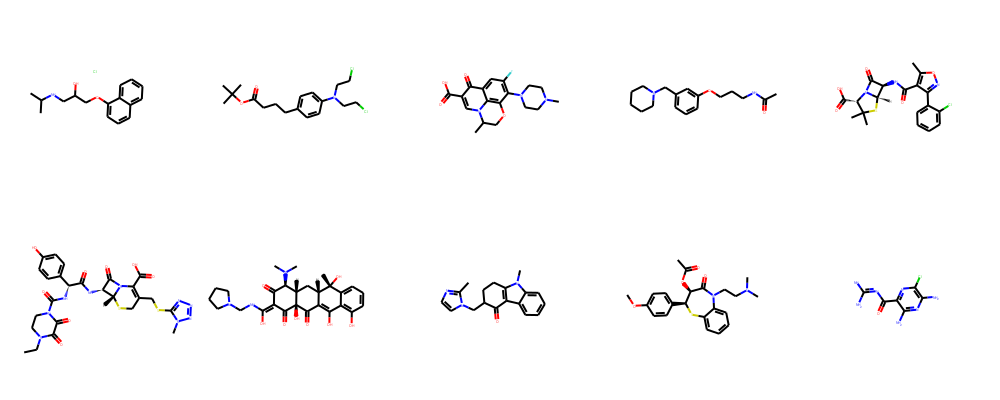

In [3]:
PandasTools.FrameToGridImage(df[:10], column='ROMol', molsPerRow=5)

In [4]:
# chainer用にデータ型を変換
x = df.iloc[:,4:].values.astype('float32')
y = df['p_np'].values.astype('int32')
indices = np.array(range(x.shape[0])) # train_test_split後も列番号を保持しておく

# train, test, valに分割
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y, indices, test_size=0.05, random_state=123)

# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train= scaler.transform(x_train)
x_test = scaler.transform(x_test)

print(type(x_train), x_train.shape, type(y_train), y_train.shape)
print(type(x_test), x_test.shape, type(y_test), y_test.shape)

<class 'numpy.ndarray'> (1937, 200) <class 'numpy.ndarray'> (1937,)
<class 'numpy.ndarray'> (102, 200) <class 'numpy.ndarray'> (102,)


In [5]:
# 説明変数と目的変数のセットで使えるように変換する
from chainer.datasets import TupleDataset
train = TupleDataset(x_train, y_train)
test = TupleDataset(x_test, y_test)

print(len(train), len(test))

1937 102


In [6]:
# イテレータの準備
from chainer.iterators import SerialIterator
train_iter = SerialIterator(train, batch_size=64, repeat=True, shuffle=True)
test_iter = SerialIterator(test, batch_size=64, shuffle=False, repeat=False)

# イテレータから1個めのマッチを取り出してみる
minibatch = train_iter.next()
print(len(minibatch))

64


In [7]:
# ニューラルネットワークの作成
# ３層のmulti layer perceptron（MLP）
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self):
        super().__init__()

        with self.init_scope():
            self.fc1 = L.Linear(None, 100)
            self.fc2 = L.Linear(None, 20)
            self.fc3 = L.Linear(None, 2)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

In [8]:
from chainer import Chain
from chainer import optimizers, training
from chainer.training import extensions

# train_iterを一回まわしたのでリセット
train_iter.reset()

# ネットワークをClassifierでラップしする
# （目的関数（デフォルトはsoftmax交差エントロピー）の計算し、損失を返す）
predictor = MLP()
net = L.Classifier(predictor)

# 最適化手法を選択して、オプティマイザを作成する
optimizer = optimizers.MomentumSGD(lr=0.1).setup(net)


# アップデータにイテレータとオプティマイザを渡す
updater = training.StandardUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, (50, 'epoch'), out='/results/')

In [9]:
from chainer.training import extensions

trainer.extend(extensions.LogReport(trigger=(5, 'epoch'), log_name='log'))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.Evaluator(test_iter, net, device=-1), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'fc1/W/data/mean', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['fc1/W/grad/mean'], x_key='epoch', file_name='mean.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.ParameterStatistics(net.predictor.fc1, {'mean': np.mean}, report_grads=True))

trainer.run()

epoch       iteration   main/loss   main/accuracy  val/main/loss  val/main/accuracy  fc1/W/data/mean  elapsed_time
5           152         0.26224     0.89484        0.448048       0.885526           -0.00181692      2.41484       
10          303         0.139982    0.945157       0.907849       0.848273           -0.00246103      5.14044       
15          454         0.106136    0.959334       1.35487        0.849836           -0.00314693      7.69944       
20          606         0.0600123   0.974712       1.29839        0.862336           -0.00345825      10.4191       
25          757         0.0467854   0.979719       1.42294        0.859786           -0.00342791      13.0327       
30          908         0.0517025   0.978684       1.35371        0.867599           -0.00401859      15.6531       
35          1060        0.0423846   0.982936       1.32677        0.859128           -0.00454369      18.2695       
40          1211        0.03925     0.983858       1.60202        

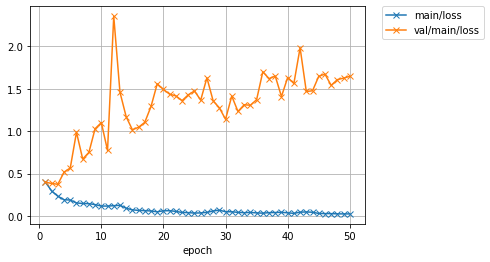

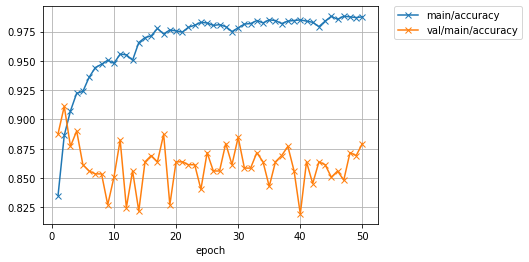

In [10]:
from IPython.display import Image, display
display(Image(filename='results/loss.png'))
display(Image(filename='results/accuracy.png'))

In [11]:
# 学習したモデルで推論してみる
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_pred = predictor(x_test)

# 推論結果の確認
print('accuracy', F.accuracy(y_pred, y_test))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred.data.argmax(axis=1))

accuracy variable(0.88235295)


array([[21,  7],
       [ 5, 69]])

In [12]:
y_pred.data.argmax(axis=1)

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1])

In [13]:
y_test

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

No. 1700
label: 1
pred : 1


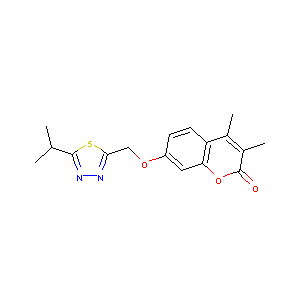

No. 1520
label: 1
pred : 1


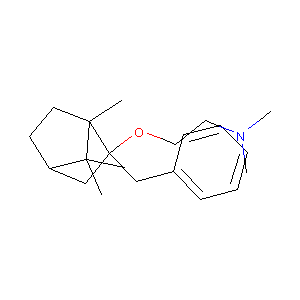

No. 1810
label: 1
pred : 1


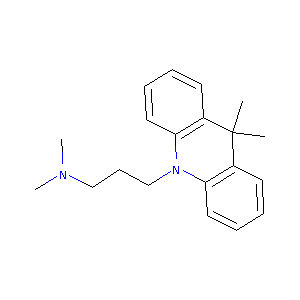

No. 1970
label: 1
pred : 1


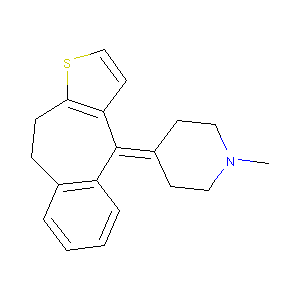

No. 372
label: 0
pred : 0


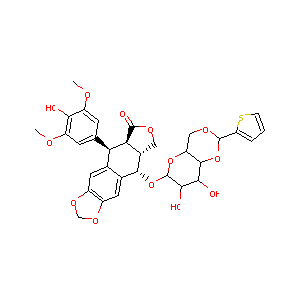

No. 1887
label: 1
pred : 1


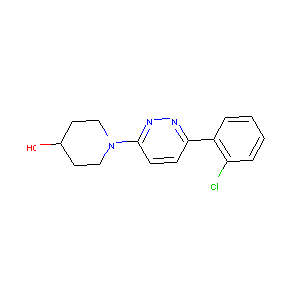

No. 1891
label: 1
pred : 1


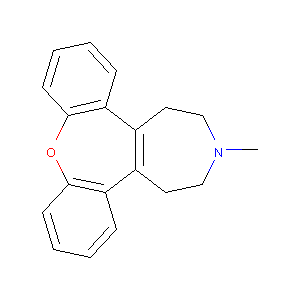

No. 1696
label: 1
pred : 1


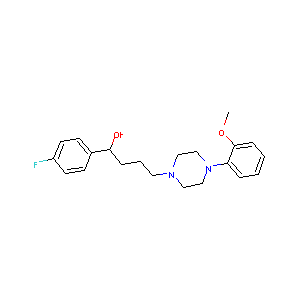

No. 945
label: 1
pred : 1


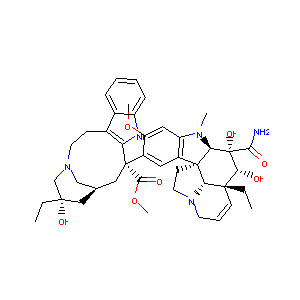

No. 928
label: 0
pred : 0


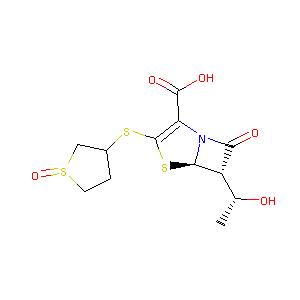

In [14]:
# 一部予測結果を見てみる
for i in range(int(len(y_pred)/10)):
    print('No.', indices_test[i])
    print('label:', y_test[i])
    print('pred :', np.argmax(y_pred[i].array))
    img = Draw.MolToImage(df.ROMol[indices_test[i]])
    display(img)